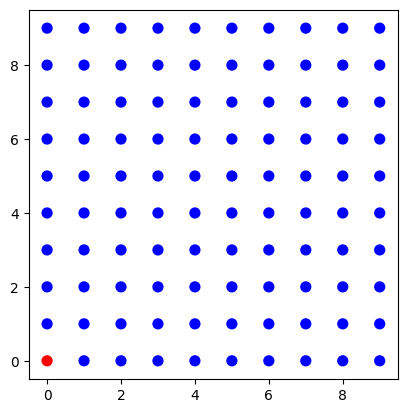

In [2]:
import matplotlib.pyplot as plt

# Define the size of the grid (n x n)
n = 10

# Specify the corner where the charging depot will be (top-left corner)
# nodes = targets + depots
# Note: If a node isn't a depot, it is a target
charging_depot_x = 0
charging_depot_y = 0

# Create a list of coordinates for all grid points
x_coords, y_coords = zip(*[(x, y) for x in range(n) for y in range(n)])

# Create a list of colors for the grid points, with a different color for the charging station
colors = ['red' if (x, y) == (charging_depot_x, charging_depot_y) else 'blue' for x, y in zip(x_coords, y_coords)]

# Create a scatter plot with dots
plt.scatter(x_coords, y_coords, c=colors, s=50)

# Set the aspect ratio to equal to make the target area square
plt.gca().set_aspect('equal', adjustable='box')

# Set axis limits to match the grid size
plt.xlim(-0.5, n - 0.5)
plt.ylim(-0.5, n - 0.5)

# Display the grid
plt.show()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i9-10900K CPU @ 3.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 1875 rows, 1694 columns and 7274 nonzeros
Model fingerprint: 0x4d83def9
Variable types: 84 continuous, 1610 integer (1610 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 10.0000000
Presolve removed 1105 rows and 250 columns
Presolve time: 0.01s
Presolved: 770 rows, 1444 columns, 3608 nonzeros
Variable types: 0 continuous, 1444 integer (1444 binary)

Root relaxation: cutoff, 46 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff

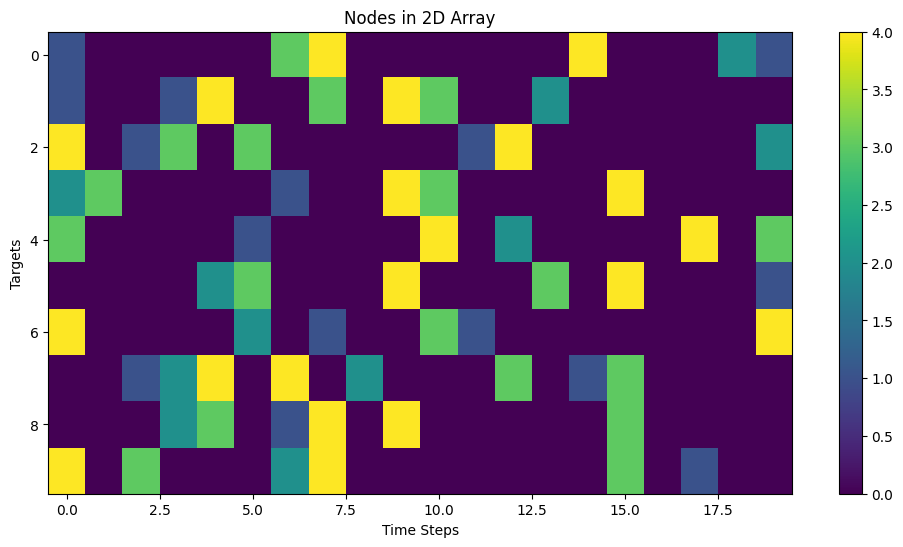

In [52]:
import random
import numpy as np
import gurobipy as gp
from gurobipy import GRB

import networkx as nx
import matplotlib.pyplot as plt

# Variables
n = 10  # Number of targets
K = 4   # Number of robots
T = 20  # Time
depots = 4
max_coverage_per_robot = 5
initial_fuel = [2*n]
min_fuel_threshold = 1.0
fuel_capacity = [10.0] * K  # Fuel capacity for each robot
fuel_consumption = [[[0.1] * T for j in range(n)] for i in range(K)]  # Max amount of fuel per robot
initial_location = [0, 2, 4, 6]  # Initial location per robot
coverage_cost = [1.0] * n  # Coverage cost for each target
    
model = gp.Model("MRPCP")   # Create Gurobi model

# Create binary variables for robot locations and target coverage
x = model.addVars(K, n, T, vtype=GRB.BINARY, name="x")
target_covered = model.addVars(K, n, T, vtype=GRB.BINARY, name="target_covered")

# Create binary variables for charging depots
charging_depot = model.addVars(n, vtype=GRB.BINARY, name="charging_depot")

# Create variables for fuel levels
fuel = model.addVars(K, T, name="fuel")
initial_fuel = model.addVars(K, name="initial_fuel")

# --------Initial conditions------------
for i in range(K):
    model.addConstr(initial_fuel[i] == 100)
    model.addConstr(x[i, initial_location[i], 0] == 1)
    model.addConstr(fuel[i, 0] == initial_fuel[i])
    
# Define the coverage cost (minimize)
model.setObjective(gp.quicksum(coverage_cost[j] * target_covered[i, j, t]
                               for j in range(n) for i in range(K) for t in range(T)),
                   GRB.MINIMIZE)

# --------Constraints------------

# ------------- Capacity & Flow Constraints -------------------
# 1: Each target must be covered at least once
for j in range(n):
    model.addConstr(gp.quicksum(target_covered[i, j, t] for i in range(K) for t in range(T)) >= 1)

# 2: Each robot can cover a maximum of max_coverage_per_robot targets in    a single time step
for i in range(K):
    model.addConstr(gp.quicksum(target_covered[i, j, t] for j in range(n) for t in range(T)) <= max_coverage_per_robot)

# 3: Ensure robots stay within their fuel constraints
for i in range(K):
    for t in range(T):
        model.addConstr(fuel[i, t] <= initial_fuel[i] + gp.quicksum(fuel_consumption[i][j][t] * x[i, j, t] for j in range(n)))

# # 3.2 : Fuel level at target visited after leaving a depot
# for i in range(K):
#     for j in range(n):
#         for t in range(1, T):
#             # If robot i enters target j at time t
#             model.addConstr(fuel[i, t] == fuel_capacity[i] - gp.quicksum(fuel_consumption[i][j][t] * x[i, j, t] for j in range(n)))
#             
# : Fuel capacity constraints for each robot
for i in range(K):
    for t in range(T):
        model.addConstr(fuel_capacity[i] >= 1)
        model.addConstr(fuel_capacity[i] <= 2 * n)

# # 4: Fuel consumption when moving
# for i in range(K):
#     for j in range(n):
#         for t in range(T):
#             model.addConstr(fuel_consumption[i][j][t] * x[i, j, t] <= fuel[i, t])
# 
# # 5: Fuel capacity constraints
# for i in range(K):
#     for t in range(T):
#         model.addConstr(fuel[i, t] <= fuel_capacity[i])
# 
# 6: Robot can only cover a target its on
for i in range(K):
    for j in range(n):
        for t in range(T):
            model.addConstr(target_covered[i, j, t] <= x[i, j, t])

# # 7: Robot movement constraints
# for i in range(K):
#     for j in range(n):
#         for t in range(1, T):
#             model.addConstr(x[i, j, t] == x[i, j, t-1] + gp.quicksum(x[k, j, t-1] for k in range(K) if k != i))
# 
# 8: Ensure that robots can only move if they have enough fuel
for i in range(K):
    for j in range(n):
        for t in range(1, T):
            model.addConstr(fuel[i, t] >= min_fuel_threshold * x[i, j, t-1] - (1 - x[i, j, t]))

# 9: Binary variables
for i in range(K):
    for j in range(n):
        for t in range(T):
            x[i, j, t].vtype = GRB.BINARY
            target_covered[i, j, t].vtype = GRB.BINARY

# 10: Number of charging depots constraint
model.addConstr(gp.quicksum(charging_depot[j] for j in range(n)) >= depots)

# ------------ Degree Constraints ----------------
# # : Ensure only one robot arrives and departs from each target
# for j in range(n):
#     model.addConstr(gp.quicksum(x[i, j, t] for i in range(K) for t in range(T)) <= 1)

# : Robot begins and ends at starting position
for i in range(K):
    model.addConstr(x[i, initial_location[i], 0] == 1)  # Robot starts at initial position
    model.addConstr(x[i, initial_location[i], T - 1] == 1)  # Robot ends at initial position

# 12: Every robot visits and leaves each target
for i in range(K):
    for j in range(n):
        model.addConstr(gp.quicksum(x[i, j, t] for t in range(T)) == 2)


# Optimize the model
model.optimize()

if model.status == GRB.OPTIMAL:
    print("Optimal solution found. Total cost:", model.ObjVal)

    # Extract the variables and values
    x_values = model.getAttr("X", x)
    target_covered_values = model.getAttr("X", target_covered)
    charging_depot_values = model.getAttr("X", charging_depot)

    # Extract robot paths
    robot_paths = [[] for _ in range(K)]
    for i in range(K):
        for j in range(n):
            for t in range(T):
                if x_values[i, j, t] > 0.5:
                    robot_paths[i].append(j)

    # Create a 2D array for displaying the nodes
    node_array = np.zeros((n, T), dtype=int)

    # Fill the node_array with target and robot labels
    for i in range(K):
        for j in range(n):
            for t in range(T):
                if x_values[i, j, t] > 0.5:
                    node_array[j, t] = i + 1
    # Plot the nodes in a 2D array
    plt.figure(figsize=(12, 6))
    plt.imshow(node_array, cmap='viridis', aspect='auto', origin='upper')
    plt.colorbar()
    plt.title('Nodes in 2D Array')
    plt.xlabel('Time Steps')
    plt.ylabel('Targets')
    plt.show()
else:
    print("No solution found. Status code:", model.status)

model.dispose();   